# Second Part Mini-Project - Graph Embeddings
> Kristof Balazs <br />
> Stefanos Kypritidis <br />

### Instructions

The first code cell lists all the libraries that need to be installed if you want to run the analysis.
The second code cell contains the utils file (over 1000 lines of code), which includes all helper functions used throughout the notebook. **For readability, it is recommended to keep this cell collapsed**. You can expand it at any time to review the implementations of the algorithms and visualizations used in the analysis.

In [29]:
%pip install networkx pandas altair nx-altair igraph leidenalg matplotlib seaborn numpy scikit-learn tqdm joblib tabulate torch torch_geometric

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: networkx in c:\users\kristof\appdata\local\programs\python\python312\lib\site-packages (3.4.2)




[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nx_altair as nxa
import os
import urllib.request
import gzip
import shutil
import zipfile
import matplotlib.colors as mcolors
from itertools import groupby
from sklearn.metrics import adjusted_rand_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.decomposition import PCA
from node2vec import Node2Vec as N2V_Algo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx, train_test_split_edges
from sklearn.preprocessing import StandardScaler
from collections import Counter

import warnings

warnings.filterwarnings('ignore')

def download_data(folder_name, base_url, files, category):
    os.makedirs("data", exist_ok=True)

    target_dir = os.path.join("data", folder_name)
    os.makedirs(target_dir, exist_ok=True)

    if category == 'email':
        for fname in files:
            url = base_url + fname
            dest_gz = os.path.join(target_dir, fname)
            dest_txt = dest_gz.replace(".gz", "")

            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, dest_gz)

            print(f"Extracting {fname}...")
            with gzip.open(dest_gz, "rb") as f_in:
                with open(dest_txt, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            os.remove(dest_gz)

            print(f"Saved extracted file to {dest_txt}\n")

        print("Email core files downloaded and extracted successfully.")

    elif category == 'twitch':
        for fname in files:
            url = base_url + fname
            dest_zip = os.path.join(target_dir, fname)

            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, dest_zip)

            print(f"Extracting PTBR files from {fname}...")
            with zipfile.ZipFile(dest_zip, 'r') as z:
                for member in z.namelist():
                    if member.startswith("__MACOSX/") or os.path.basename(member).startswith("._"):
                        continue

                    for target_file in ["musae_PTBR_edges.csv", "musae_PTBR_target.csv"]:
                        if member.endswith(target_file):
                            print(f"Extracting {member}...")
                            source = z.open(member)
                            dest_path = os.path.join(target_dir, target_file)
                            with open(dest_path, "wb") as f_out:
                                shutil.copyfileobj(source, f_out)

        print("Twitch PTBR files downloaded and extracted successfully.")

def generic_show(graph, node_color, node_size, node_tooltip, k_core=3, layout_func=nx.spring_layout, width=400, height=400):
    G = nx.k_core(graph, k=k_core)
    pos = layout_func(G)
    chart = nxa.draw_networkx(
        G=G,
        pos=pos,
        width=0.1,
        alpha=0.8,
        node_color=node_color,
        node_size=node_size,
        node_tooltip=node_tooltip
    )

    chart.properties(width=width, height=height).interactive().show()

def spy_plot_adjacency(graph, ordering_key='ground_truth', min_label_spacing=50):
    ordered_nodes = sorted(graph.nodes(), key=lambda n: graph.nodes[n][ordering_key])

    community_labels = [graph.nodes[n][ordering_key] for n in ordered_nodes]
    adj_matrix = nx.to_scipy_sparse_array(graph, nodelist=ordered_nodes)

    community_ticks = []
    unique_communities = []
    community_sizes = []
    start_index = 0
    for comm_id, group in groupby(community_labels):
        unique_communities.append(comm_id)
        group_size = len(list(group))
        community_sizes.append(group_size)
        community_ticks.append(start_index)
        start_index += group_size

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.spy(adj_matrix, markersize=0.1)
    ax.set_title(f"Adjacency Matrix Spy Plot (Ordered by '{ordering_key}')", fontsize=12)

    colors = ['#FFFFFF', '#F0F0F0']
    for i, (pos, size) in enumerate(zip(community_ticks, community_sizes)):
        ax.axhspan(pos, pos + size, facecolor=colors[i % 2], alpha=0.7, zorder=-100)

    display_labels = []
    last_label_pos = -min_label_spacing
    for i, tick_pos in enumerate(community_ticks):
        if tick_pos - last_label_pos >= min_label_spacing:
            display_labels.append(unique_communities[i])
            last_label_pos = tick_pos
        else:
            display_labels.append('')

    ax.set_xticks(community_ticks)
    ax.set_xticklabels(display_labels, rotation=90, fontsize=10)
    ax.set_yticks(community_ticks)
    ax.set_yticklabels(display_labels, fontsize=10)

    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, color='gray')
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.set_xlabel("Community ID", labelpad=15)
    ax.set_ylabel("Community ID", labelpad=15)
    plt.show()

def generic_show_static(graph, node_color=None, node_size=15, k_core=3, layout_func=nx.spring_layout, width=10, height=10):
    G = nx.k_core(graph, k=k_core)
    if len(G.nodes) == 0:
        print(f"Resulting graph is empty (no nodes with k-core >= {k_core})")
        return

    pos = layout_func(G)

    final_sizes = []
    if isinstance(node_size, (int, float)):
        final_sizes = [node_size for _ in G.nodes()]
    elif isinstance(node_size, str):
        raw_sizes = [G.nodes[n].get(node_size, 1) for n in G.nodes()]
        min_s, max_s = min(raw_sizes), max(raw_sizes)
        if max_s == min_s:
            final_sizes = [300 for _ in raw_sizes]
        else:
            final_sizes = [50 + ((x - min_s) / (max_s - min_s)) * 450 for x in raw_sizes]

    sm = None
    legend_handles = []

    raw_colors = [G.nodes[n].get(node_color, 0) for n in G.nodes()]
    unique_vals = sorted(list(set(raw_colors)))

    is_continuous = len(unique_vals) > 10 or (len(unique_vals) > 0 and isinstance(unique_vals[0], float))

    if is_continuous:
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(raw_colors), vmax=max(raw_colors))
        final_colors = [cmap(norm(val)) for val in raw_colors]
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
    else:
        cmap = plt.cm.tab20 if len(unique_vals) > 10 else plt.cm.tab10
        val_to_color = {val: cmap(i) for i, val in enumerate(unique_vals)}
        final_colors = [val_to_color[val] for val in raw_colors]
        for val, color in val_to_color.items():
            legend_handles.append(mpatches.Patch(color=color, label=str(val)))

    fig, ax = plt.subplots(figsize=(width, height))

    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.4, width=0.1, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=final_colors, node_size=final_sizes, alpha=0.75)

    if is_continuous:
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label(node_color)
    else:
        ax.legend(handles=legend_handles, title=node_color, loc='best')

    ax.axis('off')
    plt.show()

def load_email(directed=False):
    edge_list_path = 'data/email/email-Eu-core.txt'
    nodes_labels_path = 'data/email/email-Eu-core-department-labels.txt'

    G = nx.read_edgelist(edge_list_path,
                         delimiter=' ',
                         nodetype=int,
                         create_using=nx.DiGraph)

    if not directed:
        G = G.to_undirected()

    df_labels = pd.read_csv(
        nodes_labels_path,
        sep=' ',
        names=['node', 'department_id']
    )

    ground_truth_dict = pd.Series(
        df_labels.department_id.values,
        index=df_labels.node
    ).to_dict()

    nx.set_node_attributes(G, ground_truth_dict, 'ground_truth')
    G.remove_edges_from(nx.selfloop_edges(G))

    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)

    return G

def load_twitch_user_attributes(G):
    df = pd.read_csv("data/twitch/musae_PTBR_target.csv")
    attr_dict = {
        row["new_id"]: {
            "id": row["new_id"],
            "account_age_days": row["days"],
            "is_mature": row["mature"],
            "total_views": row["views"],
            "is_partner": row["partner"],
        }
        for _, row in df.iterrows()}

    df = df[["days", "mature", "views", "partner", "new_id"]].rename(columns={"new_id": "id",
                                            "days": "account_age_days", "mature": "is_mature",
                                            "views": "total_views", "partner": "is_partner"}).copy()
    nx.set_node_attributes(G, attr_dict)
    return G, df

def enrich_graph_with_centrality(graph, centrality_funcs):
    if not graph:
        print("Graph is empty, returning.")
        return graph

    first_node = next(iter(graph.nodes()))

    for func in centrality_funcs:
        attribute_name = func.__name__

        if attribute_name in graph.nodes[first_node]:
            print(f"Skipping '{attribute_name}': attribute already exists.")
            continue

        print(f"Calculating and adding node attribute '{attribute_name}'...")
        scores = func(graph)
        nx.set_node_attributes(graph, dict(scores), attribute_name)

    return graph

def load_twitch_robust():
    print("--- Loading Twitch Data (Robust Method) ---")

    df_edges = pd.read_csv("data/twitch/musae_PTBR_edges.csv")
    G = nx.from_pandas_edgelist(df_edges, source='from', target='to')

    df_targets = pd.read_csv("data/twitch/musae_PTBR_target.csv")

    attr_dict = {}
    for _, row in df_targets.iterrows():
        node_id = int(row['new_id'])

        is_mature = 1 if row['mature'] == True else 0
        is_partner = 1 if row['partner'] == True else 0

        attr_dict[node_id] = {
            "days": row['days'],
            "views": row['views'],
            "partner": is_partner,
            "mature": is_mature,
            "ground_truth": is_mature 
        }

    nx.set_node_attributes(G, attr_dict)

    valid_nodes = set(attr_dict.keys())
    nodes_to_remove = [n for n in G.nodes() if n not in valid_nodes]
    if nodes_to_remove:
        print(f"Removing {len(nodes_to_remove)} nodes without attributes.")
        G.remove_nodes_from(nodes_to_remove)

    return G

def profile_graph_statistics(G, target_attr="ground_truth"):
    """
    Computes and plots:
    1. Node distribution per department (Class Balance)
    2. Degree distribution (Structural Connectivity)
    """
    print(f"=== Graph Profile: {target_attr} ===")

    labels = [G.nodes[n].get(target_attr) for n in G.nodes() if G.nodes[n].get(target_attr) is not None]
    degrees = [d for n, d in G.degree()]

    label_counts = Counter(labels)
    avg_degree = np.mean(degrees)
    max_degree = np.max(degrees)

    print(f"Total Labeled Nodes: {len(labels)}")
    print(f"Number of Departments: {len(label_counts)}")
    print(f"Average Degree: {avg_degree:.2f}")
    print(f"Max Degree (Hub nodes): {max_degree}")

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    label_df = pd.DataFrame(label_counts.items(), columns=['Dept', 'Count']).sort_values('Count', ascending=False)
    sns.barplot(data=label_df, x='Dept', y='Count', palette='viridis')
    plt.title("Distribution of Nodes per Department")
    plt.xticks(rotation=90, fontsize=8) 
    plt.ylabel("Number of Nodes")

    plt.subplot(1, 2, 2)
    sns.histplot(degrees, kde=True, color='salmon', bins=30)
    plt.title("Node Degree Distribution")
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def summary_stats(graph):
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")

    degrees = [d for n, d in graph.degree()]
    avg_degree = sum(degrees) / graph.number_of_nodes()
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Density: {nx.density(graph):.4f}")

    avg_clustering = nx.average_clustering(graph)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

    if nx.is_connected(graph):
        print("Graph is connected.")
        print(f"Radius: {nx.radius(graph)}")
        print(f"Diameter: {nx.diameter(graph)}")
        print(f"Average shortest path length: {nx.average_shortest_path_length(graph):.2f}")
    else:
        num_components = nx.number_connected_components(graph)
        print(f"Graph is not connected. It has {num_components} connected components.")

        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        print(f"Stats for the largest connected component ({subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges):")
        print(f"  - Radius: {nx.radius(subgraph)}")
        print(f"  - Diameter: {nx.diameter(subgraph)}")
        print(f"  - Average shortest path length: {nx.average_shortest_path_length(subgraph):.2f}")

def get_spectral_embedding(G, dim=16, seed=42):
    """
    Implements Laplacian Eigenmaps.
    Uses the spectral properties of the Laplacian matrix L = D - A.
    """
    print(f"   > Computing Spectral Embedding (d={dim})...")

    adj = nx.to_scipy_sparse_array(G)

    se = SpectralEmbedding(n_components=dim, affinity='precomputed', random_state=seed)
    embeddings = se.fit_transform(adj)

    return embeddings

def get_node2vec_embedding(G, dim=16, p=1.0, q=1.0, walks=10, length=80, seed=42):
    """
    Implements Node2Vec.
    Uses biased random walks (p, q) and Skip-Gram.
    """
    print(f"   > Computing Node2Vec Embedding (d={dim}, p={p}, q={q})...")

    node2vec_model = N2V_Algo(
        G, 
        dimensions=dim, 
        walk_length=length, 
        num_walks=walks, 
        p=p, 
        q=q, 
        workers=1, 
        quiet=True,
        seed=seed
    )

    model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

    nodes = list(G.nodes())
    embeddings = np.array([model.wv[str(n)] for n in nodes])

    return embeddings

def visualize_embeddings_side_by_side(G, emb_spectral, emb_n2v, title_prefix, ground_truth_attr='ground_truth'):
    """
    Reduces dimensions to 2D (using t-SNE) and plots side-by-side.
    t-SNE for visualization.
    """
    nodes = list(G.nodes())
    labels = [G.nodes[n].get(ground_truth_attr) for n in nodes]

    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')

    print(f"   > Projecting to 2D using t-SNE for {title_prefix}...")
    vis_spectral = tsne.fit_transform(emb_spectral)
    vis_n2v = tsne.fit_transform(emb_n2v)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    sc1 = axes[0].scatter(vis_spectral[:,0], vis_spectral[:,1], c=labels, cmap='tab20', s=15, alpha=0.7)
    axes[0].set_title(f"Spectral Embedding (Laplacian)\n{title_prefix}")
    axes[0].axis('off')

    sc2 = axes[1].scatter(vis_n2v[:,0], vis_n2v[:,1], c=labels, cmap='tab20', s=15, alpha=0.7)
    axes[1].set_title(f"Node2Vec (Random Walk)\n{title_prefix}")
    axes[1].axis('off')

    plt.suptitle(f"Embedding Comparison: {title_prefix}", fontsize=16)

    if len(set(labels)) <= 20: 
        cbar = plt.colorbar(sc2, ax=axes.ravel().tolist())
        cbar.set_label(ground_truth_attr)

    plt.show()

def run_embedding_analysis(G, name, ground_truth_attr, p=1.0, q=1.0):
    print(f"\n=== Running Analysis for {name} ===")

    emb_spec = get_spectral_embedding(G, dim=32)

    emb_n2v = get_node2vec_embedding(G, dim=32, p=p, q=q)

    visualize_embeddings_side_by_side(G, emb_spec, emb_n2v, name, ground_truth_attr)

    return emb_spec, emb_n2v

def evaluate_embeddings(G, embeddings, target_attr, name, method_name):
    """
    Trains a Logistic Regression model on the embeddings to predict node attributes.
    Returns the accuracy and the confusion matrix (plotting is handled outside).
    """
    print(f"--- Evaluating {method_name} on {name} ---")

    nodes = list(G.nodes())
    y = []
    valid_indices = []

    for i, node in enumerate(nodes):
        label = G.nodes[node].get(target_attr)
        if label is not None:
            y.append(label)
            valid_indices.append(i)

    X = embeddings[valid_indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(random_state=42, max_iter=1000) 
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"   > Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)

    return acc, cm

def compare_downstream_tasks(G, emb_spec, emb_n2v, name, target_attr):
    """
    Runs evaluation on both embeddings and plots a 1x3 side-by-side figure:
    [Spectral CM] | [Node2Vec CM] | [Accuracy Bar Chart]
    """
    print(f"\n=== Downstream Task: Node Classification ({name}) ===")

    score_spec, cm_spec = evaluate_embeddings(G, emb_spec, target_attr, name, "Spectral")
    score_n2v, cm_n2v = evaluate_embeddings(G, emb_n2v, target_attr, name, "Node2Vec")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    def plot_heatmap(ax, cm, title):

        annotate = True if len(cm) <= 10 else False

        sns.heatmap(cm, annot=annotate, fmt='d', cmap='Blues', cbar=True, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plot_heatmap(axes[0], cm_spec, f"Confusion Matrix: Spectral\n{name}")

    plot_heatmap(axes[1], cm_n2v, f"Confusion Matrix: Node2Vec\n{name}")

    results = pd.DataFrame({
        'Method': ['Spectral', 'Node2Vec'],
        'Accuracy': [score_spec, score_n2v]
    })

    sns.barplot(data=results, x='Method', y='Accuracy', palette=['skyblue', 'salmon'], ax=axes[2])
    axes[2].set_title(f"Node Classification Accuracy\n{name} (Target: {target_attr})")
    axes[2].set_ylim(0, 1.0)
    axes[2].set_ylabel("Accuracy Score")

    for index, row in results.iterrows():
        axes[2].text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha="center")

    plt.tight_layout()
    plt.show()

def evaluate_multiple_classifiers(G, embeddings, target_attr):
    """
    Extracts valid labels, splits data, and trains 4 different classification models.
    Returns a dictionary of accuracies.
    """

    nodes = list(G.nodes())
    y = []
    valid_indices = []

    for i, node in enumerate(nodes):
        label = G.nodes[node].get(target_attr)
        if label is not None:
            y.append(label)
            valid_indices.append(i)

    X = embeddings[valid_indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression\n(Baseline)': LogisticRegression(random_state=42, max_iter=1000),
        'SVM (RBF Kernel)': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'MLP (Neural Net)': MLPClassifier(
            hidden_layer_sizes=(64, 32), 
            activation='relu',     
            solver='adam',         
            alpha=0.0001,          
            max_iter=1000, 
            random_state=42
        )
    }

    results = {}

    for clf_name, clf in models.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[clf_name] = accuracy_score(y_test, y_pred)

    return results

def compare_classifier_heads(G, emb_spec, emb_n2v, name, target_attr):
    """
    Evaluates multiple classifiers for both Spectral and Node2Vec embeddings 
    and plots a grouped bar chart.
    """
    print(f"\n=== Comparing Classification Heads ({name}) ===")

    print("   > Training models on Spectral Embeddings...")
    spec_results = evaluate_multiple_classifiers(G, emb_spec, target_attr)

    print("   > Training models on Node2Vec Embeddings...")
    n2v_results = evaluate_multiple_classifiers(G, emb_n2v, target_attr)

    records = []
    for clf_name, acc in spec_results.items():
        records.append({'Embedding': 'Spectral', 'Classifier': clf_name, 'Accuracy': acc})
    for clf_name, acc in n2v_results.items():
        records.append({'Embedding': 'Node2Vec', 'Classifier': clf_name, 'Accuracy': acc})

    df_results = pd.DataFrame(records)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_results, x='Classifier', y='Accuracy', hue='Embedding', palette=['skyblue', 'salmon'])

    plt.title(f"Classifier Head Comparison\n{name} (Target: {target_attr})", fontsize=14)
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy Score", fontsize=12)
    plt.xlabel("") 

    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            ax.annotate(f"{height:.2f}", 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 8), textcoords='offset points')

    plt.legend(title='Embedding Method', loc='best')
    plt.tight_layout()
    plt.show()

def optimize_node2vec_params_both_tasks(G, target_attr, name, p_values, q_values):
    """
    Grid search for p and q parameters evaluating BOTH Node Classification and Link Prediction.
    Plots two side-by-side heatmaps.
    """
    print(f"\n=== Optimizing Node2Vec Parameters for {name} (Both Tasks) ===")

    results = []

    print("   > Preparing Link Prediction train/test split...")
    G_train, pos_edges, neg_edges = get_link_prediction_data(G)

    nodes_list_train = list(G_train.nodes())
    node_idx_train = {n: i for i, n in enumerate(nodes_list_train)}
    eval_edges = [(u, v, 1) for u, v in pos_edges] + [(u, v, 0) for u, v in neg_edges]

    total_combinations = len(p_values) * len(q_values)
    count = 0

    for p in p_values:
        for q in q_values:
            count += 1
            print(f"   > Testing combination {count}/{total_combinations}: p={p}, q={q}...")

            emb_full = get_node2vec_embedding(G, dim=32, p=p, q=q, walks=10, length=40, seed=42)

            nodes = list(G.nodes())
            y = []
            valid_indices = []
            for i, node in enumerate(nodes):
                label = G.nodes[node].get(target_attr)
                if label is not None:
                    y.append(label)
                    valid_indices.append(i)

            X = emb_full[valid_indices]
            X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X, y, test_size=0.2, random_state=42)
            clf = LogisticRegression(random_state=42, max_iter=500)
            clf.fit(X_train_nc, y_train_nc)
            acc = accuracy_score(y_test_nc, y_pred=clf.predict(X_test_nc))

            emb_train = get_node2vec_embedding(G_train, dim=32, p=p, q=q, walks=10, length=40, seed=42)

            y_true_lp = []
            y_scores_lp = []
            for u, v, label in eval_edges:
                if u in node_idx_train and v in node_idx_train:
                    u_vec = emb_train[node_idx_train[u]].reshape(1, -1)
                    v_vec = emb_train[node_idx_train[v]].reshape(1, -1)

                    score = cosine_similarity(u_vec, v_vec)[0][0]
                    y_true_lp.append(label)
                    y_scores_lp.append(score)

            auc = roc_auc_score(y_true_lp, y_scores_lp)

            results.append({
                'p': p,
                'q': q,
                'Accuracy': acc,
                'AUC': auc
            })

    df_res = pd.DataFrame(results)
    heatmap_acc = df_res.pivot(index='p', columns='q', values='Accuracy')
    heatmap_auc = df_res.pivot(index='p', columns='q', values='AUC')

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(heatmap_acc, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Accuracy'}, ax=axes[0])
    axes[0].set_title(f"Node Classification Accuracy\n{name} (Target: {target_attr})")
    axes[0].set_xlabel("q (In-Out Parameter)")
    axes[0].set_ylabel("p (Return Parameter)")
    axes[0].text(0.5, -0.2, "Low q = DFS (Explore Outward)", ha='center', transform=axes[0].transAxes, fontsize=9)
    axes[0].text(-0.2, 0.5, "Low p = BFS (Stay Local)", va='center', rotation=90, transform=axes[0].transAxes, fontsize=9)

    sns.heatmap(heatmap_auc, annot=True, fmt=".3f", cmap="magma", cbar_kws={'label': 'ROC-AUC'}, ax=axes[1])
    axes[1].set_title(f"Link Prediction Performance (AUC)\n{name}")
    axes[1].set_xlabel("q (In-Out Parameter)")
    axes[1].set_ylabel("p (Return Parameter)")
    axes[1].text(0.5, -0.2, "Low q = DFS (Explore Outward)", ha='center', transform=axes[1].transAxes, fontsize=9)

    plt.tight_layout()
    plt.show()

    best_acc_row = df_res.loc[df_res['Accuracy'].idxmax()]
    best_auc_row = df_res.loc[df_res['AUC'].idxmax()]

    print(f"\nBest Config for Node Classification: p={best_acc_row['p']}, q={best_acc_row['q']} -> Accuracy: {best_acc_row['Accuracy']:.4f}")
    print(f"Best Config for Link Prediction:     p={best_auc_row['p']}, q={best_auc_row['q']} -> AUC: {best_auc_row['AUC']:.4f}")

    return df_res

def get_link_prediction_data(G, test_ratio=0.1, seed=42):
    """
    Splits graph edges into Train (visible) and Test (hidden) sets.
    Also generates negative samples (non-existent edges) for testing.
    """
    print("   > Splitting edges for Link Prediction...")

    G_train = G.copy()
    edges = list(G.edges())
    num_test = int(len(edges) * test_ratio)

    random.seed(seed)
    random.shuffle(edges)

    test_edges = edges[:num_test]
    train_edges = edges[num_test:]

    G_train.remove_edges_from(test_edges)

    negative_edges = []
    nodes = list(G.nodes())
    all_edges_set = set(G.edges())

    while len(negative_edges) < num_test:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and not G.has_edge(u, v) and (u, v) not in all_edges_set:
            negative_edges.append((u, v))
            all_edges_set.add((u, v)) 

    return G_train, test_edges, negative_edges

def evaluate_link_prediction(G, name, method="node2vec"):
    """
    Full pipeline: Split -> Embed -> Predict -> Score (AUC)
    """
    print(f"\n--- Link Prediction Pipeline: {name} ({method}) ---")

    G_train, pos_edges, neg_edges = get_link_prediction_data(G)

    if method == "spectral":
        embeddings = get_spectral_embedding(G_train, dim=32)
    else:

        embeddings = get_node2vec_embedding(G_train, dim=32, p=1.0, q=1.0, walks=10)

    nodes_list = list(G_train.nodes())
    node_idx = {n: i for i, n in enumerate(nodes_list)}

    y_true = []
    y_scores = []

    eval_edges = [(u, v, 1) for u, v in pos_edges] + [(u, v, 0) for u, v in neg_edges]

    for u, v, label in eval_edges:
        if u in node_idx and v in node_idx:
            u_vec = embeddings[node_idx[u]].reshape(1, -1)
            v_vec = embeddings[node_idx[v]].reshape(1, -1)

            if method == "spectral":

                dist = euclidean_distances(u_vec, v_vec)[0][0]
                score = -dist 
            else:

                score = cosine_similarity(u_vec, v_vec)[0][0]

            y_true.append(label)
            y_scores.append(score)

    auc = roc_auc_score(y_true, y_scores)
    print(f"   > Link Prediction AUC: {auc:.4f}")
    return auc

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=32, heads=8):
        super(GAT, self).__init__()
        # Increased heads and hidden_dim for better department separation
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=0.5, add_self_loops=True)
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False, dropout=0.5, add_self_loops=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x) 
        # ELU is preferred over ReLU for GAT as it handles negative values better
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1) 

def run_gat_ml_side_by_side(G, name="Email-Eu-Core", target_attr="ground_truth", epochs=1000):
    print(f"\n=== GAT ML Pipeline: {name} ===")

    nodes = list(G.nodes())
    y = [G.nodes[n].get(target_attr) for n in nodes]
    valid_mask = [val is not None for val in y]
    y_filtered = [y[i] for i in range(len(y)) if valid_mask[i]]
    unique_labels = sorted(list(set(y_filtered)))
    label_map = {lbl: i for i, lbl in enumerate(unique_labels)}

    H = G.subgraph([nodes[i] for i in range(len(nodes)) if valid_mask[i]]).copy()
    data = from_networkx(H)
    data.y = torch.tensor([label_map[H.nodes[n][target_attr]] for n in H.nodes()], dtype=torch.long)
    data.x = torch.eye(H.number_of_nodes(), dtype=torch.float)

    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    train_size = int(0.8 * num_nodes)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[indices[:train_size]] = True
    test_mask = ~train_mask

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GAT(num_features=data.num_features, num_classes=len(unique_labels)).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)

    history = {'loss': [], 'acc': []}

    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            correct = (pred[test_mask] == data.y[test_mask]).sum()
            acc = int(correct) / int(test_mask.sum())

        history['loss'].append(loss.item())
        history['acc'].append(acc)

        if epoch % 200 == 0:
            print(f"   Epoch {epoch:04d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.plot(history['loss'], color='tab:red', alpha=0.8, label='Train Loss')
    ax2.plot(history['acc'], color='tab:blue', alpha=0.8, label='Test Accuracy')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax2.set_ylabel('Accuracy', color='tab:blue')
    plt.title(f"Learning Dynamics\n{name}")
    ax1.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    model.eval()
    with torch.no_grad():
        final_out = model(data)
        y_pred = final_out[test_mask].argmax(dim=1).cpu().numpy()
        y_true = data.y[test_mask].cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, cmap='Blues', annot=False, cbar=True)
    plt.title(f"Confusion Matrix: GAT\n(42 Departments)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.tight_layout()
    plt.show()

    return acc

class GATLinkPredictor(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=16, out_dim=16, heads=4):
        super(GATLinkPredictor, self).__init__()

        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=0.6, add_self_loops=True)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False, dropout=0.6, add_self_loops=True)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):

        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

def run_gat_link_prediction(G, name="Email-Eu-Core", epochs=1000):
    print(f"\n=== GAT Link Prediction Pipeline: {name} ===")

    data = from_networkx(G)
    data.x = torch.eye(data.num_nodes, dtype=torch.float)

    data = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GATLinkPredictor(data.num_features).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    history = {'loss': [], 'auc': []}

    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()

        z = model.encode(data.x, data.train_pos_edge_index)

        pos_out = model.decode(z, data.train_pos_edge_index)
        neg_edge_index = torch.randint(0, data.num_nodes, data.train_pos_edge_index.size(), device=device)
        neg_out = model.decode(z, neg_edge_index)

        loss = F.binary_cross_entropy_with_logits(
            torch.cat([pos_out, neg_out]), 
            torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))]).to(device)
        )

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)

            pos_test_out = model.decode(z, data.test_pos_edge_index)
            neg_test_out = model.decode(z, data.test_neg_edge_index)

            y_pred = torch.cat([pos_test_out, neg_test_out]).sigmoid().cpu().numpy()
            y_true = torch.cat([torch.ones(pos_test_out.size(0)), torch.zeros(neg_test_out.size(0))]).numpy()
            auc = roc_auc_score(y_true, y_pred)

        history['loss'].append(loss.item())
        history['auc'].append(auc)

        if epoch % 50 == 0:
            print(f"   Epoch {epoch:03d} | Loss: {loss.item():.4f} | AUC: {auc:.4f}")

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.plot(history['loss'], color='tab:red', label='Train Loss')
    ax2.plot(history['auc'], color='tab:orange', label='Test AUC')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss', color='tab:red')
    ax2.set_ylabel('ROC-AUC', color='tab:orange')
    plt.title(f"Link Prediction Dynamics\n{name}")

    plt.subplot(1, 2, 2)
    plt.hist(y_pred[y_true == 1], bins=30, alpha=0.5, label='Positive Edges', color='green')
    plt.hist(y_pred[y_true == 0], bins=30, alpha=0.5, label='Negative Samples', color='red')
    plt.title("Edge Similarity Score Distribution")
    plt.xlabel("Probability Score (Sigmoid)"); plt.ylabel("Frequency")
    plt.legend()

    plt.tight_layout(); plt.show()
    return auc

# Dataset explanation

For our project, we've selected a dataset constructed from internal email exchanges within a large European research institution. The dataset captures anonymized records of all emails sent between members of the institution. In the corresponding network, an edge
$(u,v)$ exists whenever person $u$ sent at least one email to person $v$. Because the data only includes communication among institutional members, it represents a closed network without any external incoming or outgoing messages.

An important feature of this dataset is the availability of “ground-truth” community labels. Each individual belongs to exactly one of the institution’s 42 departments, providing predefined community memberships that can be used to evaluate our community detection methods.

The dataset can be accessed from the following link (https://snap.stanford.edu/data/email-Eu-core.html), or downloaded and put inside the correct folder by executing the following cell.

In [31]:
# Download Data
files_email = ["email-Eu-core.txt.gz", "email-Eu-core-department-labels.txt.gz"]
download_data('email', "https://snap.stanford.edu/data/", files_email, category='email')
download_data('twitch', "https://github.com/Carda01/community_detection/releases/download/1.0/", ['twitch_data.zip'], category='twitch')

Extracting email-Eu-core.txt.gz...
Saved extracted file to data\email\email-Eu-core.txt

Extracting email-Eu-core-department-labels.txt.gz...
Saved extracted file to data\email\email-Eu-core-department-labels.txt

Email core files downloaded and extracted successfully.
Extracting PTBR files from twitch_data.zip...
Extracting twitch_data/musae_PTBR_target.csv...
Extracting twitch_data/musae_PTBR_edges.csv...
Twitch PTBR files downloaded and extracted successfully.


In [32]:
# Load First Graph
print("--- Loading Email Graph ---")
G_email = load_email(directed=False)

--- Loading Email Graph ---


# Part 0: Graph Topology and Statistics

For the following preliminary analysis we made the graph undirected, so as long as there is an edge between u and v (no matter the direction), in the newly built undirected graph there will be an edge between u and v. Also we've removed from the graph those nodes which have just self loops and no other edges to other nodes.

In [33]:
summary_stats(G_email)

Number of nodes: 986
Number of edges: 16064
Average degree: 32.58
Density: 0.0331
Average clustering coefficient: 0.4071
Graph is connected.
Radius: 4
Diameter: 7
Average shortest path length: 2.59


To have better readability we will also often use the k core of a graph rather than the whole graph when visualizing.

Calculating and adding node attribute 'degree'...


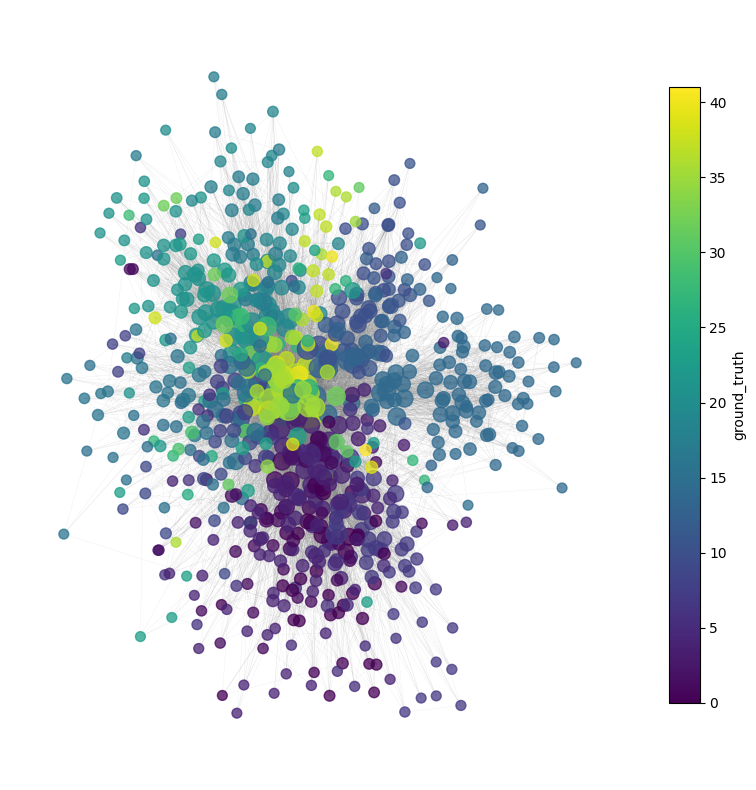

In [34]:
enrich_graph_with_centrality(G_email, [nx.degree])
generic_show_static(G_email, node_color='ground_truth', node_size='degree', k_core=5)

The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.

=== Graph Profile: ground_truth ===
Total Labeled Nodes: 986
Number of Departments: 42
Average Degree: 32.58
Max Degree (Hub nodes): 345


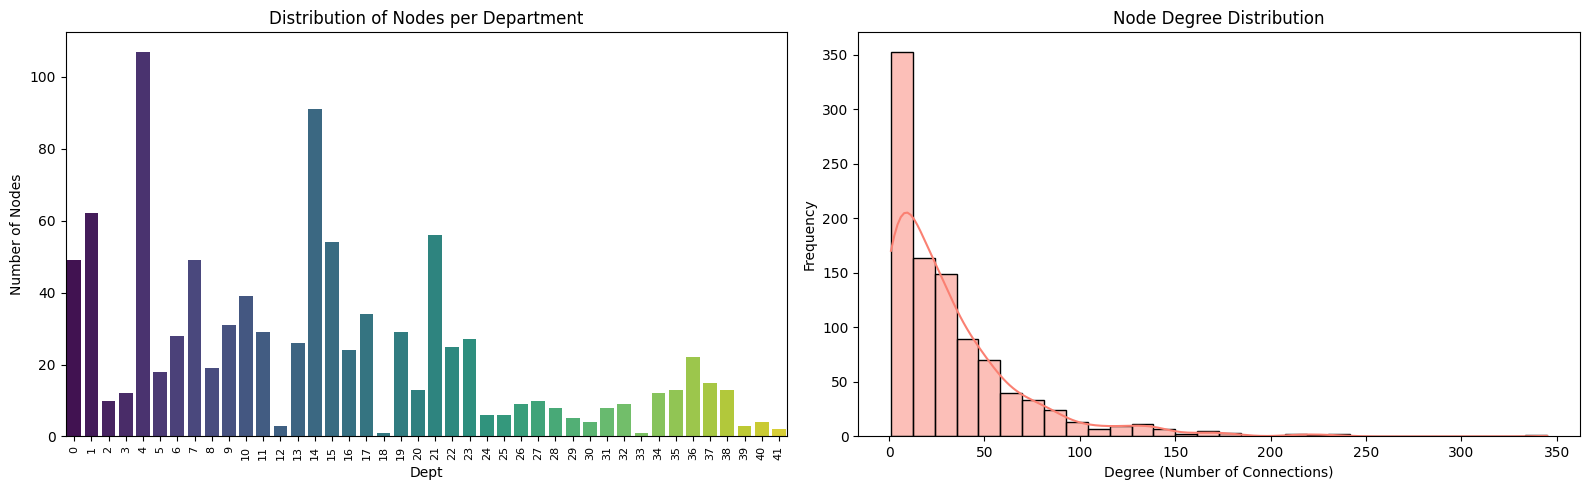

In [35]:
profile_graph_statistics(G_email)

### Spy Plot

The sparsity plot (spyplot) of the adjacency matrix with the nodes ordered by their department is a sanity check.

If we get diagonal blocks it means that people inside their department sends each other a lot of mails, while they tend to send few to people of other departments. And this is actually what we get. At the same time, there are some people (from departments 32-37 and especially department 36) who sends emails to all the people. Our hypothesis is that they are the managers or system admin department. We can already predict that it will be hard for these departments to separate them into their respective communities. Additionally, we can notice that the communities vary drastically in size, and some are very small, like the 18th or the 12th.

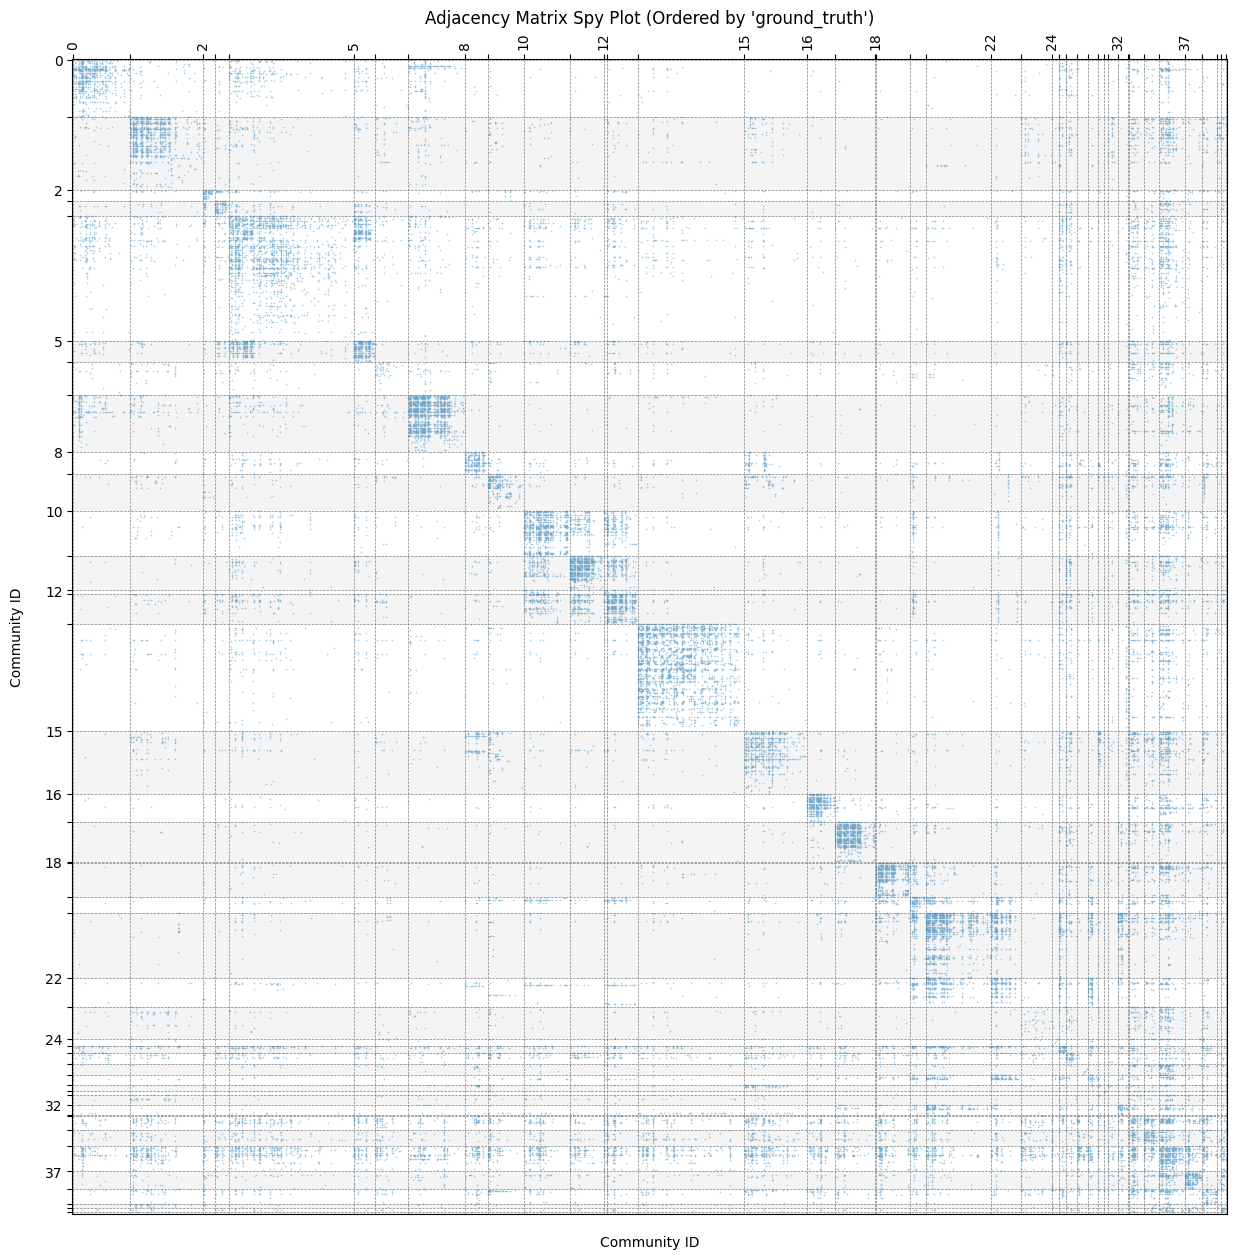

In [36]:
spy_plot_adjacency(G_email)

# Part 1: Shallow Embeddings

### Spectral Embedding (Laplacian Eigenmaps)

This uses the eigenvalues/eigenvectors of the Graph Laplacian to map nodes. It relies on global matrix factorization.

### Node2Vec (Random Walk)

This uses biased random walks ($p$ and $q$ parameters) and the Skip-Gram neural network model (from Word2Vec) to learn local neighborhoods.


=== Running Analysis for Email-Eu-Core ===
   > Computing Spectral Embedding (d=32)...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=1.0)...
   > Projecting to 2D using t-SNE for Email-Eu-Core...


  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


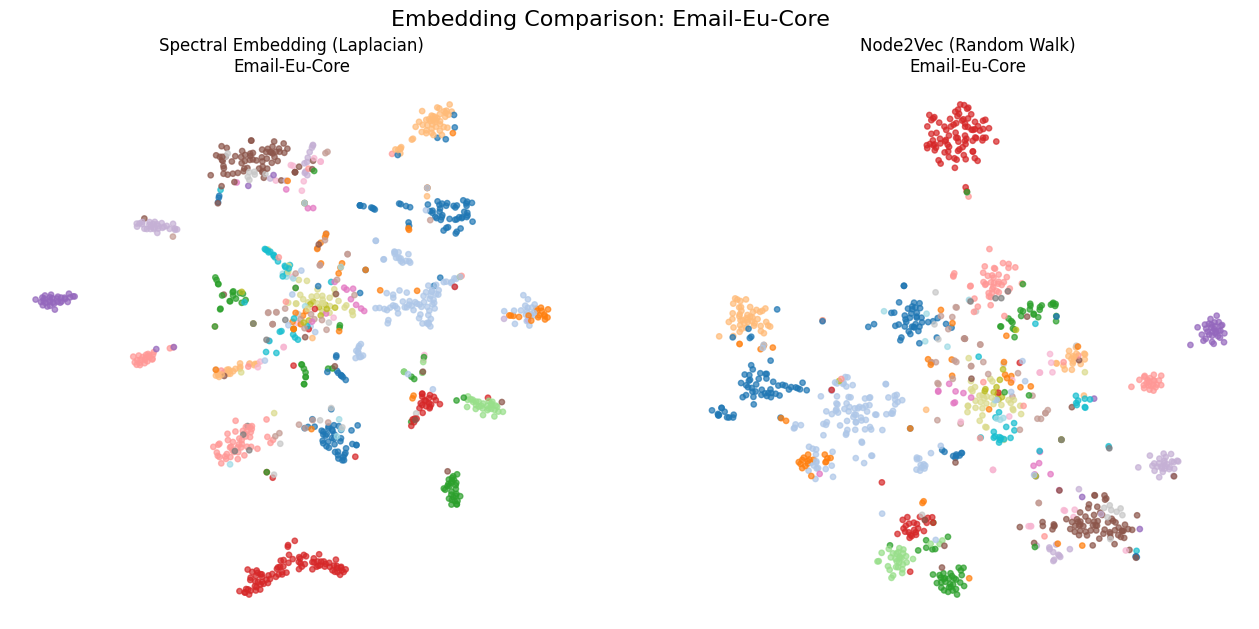

In [37]:
# Email-Eu-core Analysis
# Ground truth is department ID
# Using standard p=1, q=1 for generic exploration
emb_email_spec, emb_email_n2v = run_embedding_analysis(G_email, "Email-Eu-Core", "ground_truth", p=1.0, q=1.0)

### Conclusions so far for the EU-core email graph

Spectral Embedding (Left): The plot shows distinct, isolated "islands" or tight blobs. Several groups are pushed far to the periphery, completely separated from the central cluster. The structure appears rigid and geometric.

Node2Vec (Right): The plot shows a more cohesive, organic "cloud." While the colors (departments) still cluster together, the groups are closer to one another, forming a continuous global structure rather than fragmented islands.

**Explanation**:

Minimizing Cuts: Spectral embedding is derived from the Laplacian Matrix ($L = D - A$). Its objective function mathematically tries to solve the RatioCut or Normalized Cut problem.

Global Separation: The algorithm looks for the "weakest links" in the graph to separate it into pieces. It creates embeddings where nodes in the same cluster are extremely close, but different clusters are pushed as far apart as possible to minimize the "energy" of the connections between them.

The "exploded" look in the Email graph accurately reflects the "Cut" theory. It has successfully identified departments that are somewhat insular, geometrically forcing them apart to satisfy the condition of minimizing edges between groups.

**Why Node2Vec looks like a "Connected Cloud"**

Random Walk Probability: Node2Vec does not try to "cut" the graph. Instead, it defines similarity based on transition probabilities $P(v|u)$. It learns embeddings such that nodes that frequently co-occur on random walks are close in vector space.

Even if two departments are distinct, email communication often involves "bridges" (e.g., managers or administrative staff who email everyone). A random walker crosses these bridges frequently. Node2Vec captures this interconnectivity, keeping the clusters "glued" together in a central mass rather than breaking them apart.

By using the Skip-Gram model (from Word2Vec), Node2Vec allows for a "soft" definition of neighborhoods. It preserves the local "homophily" (similar nodes stay close) without enforcing the rigid global partitioning that Spectral embedding does.

### Node Classification Visualization (Shallow Embeddings)

The pileline for node classification is as follows:

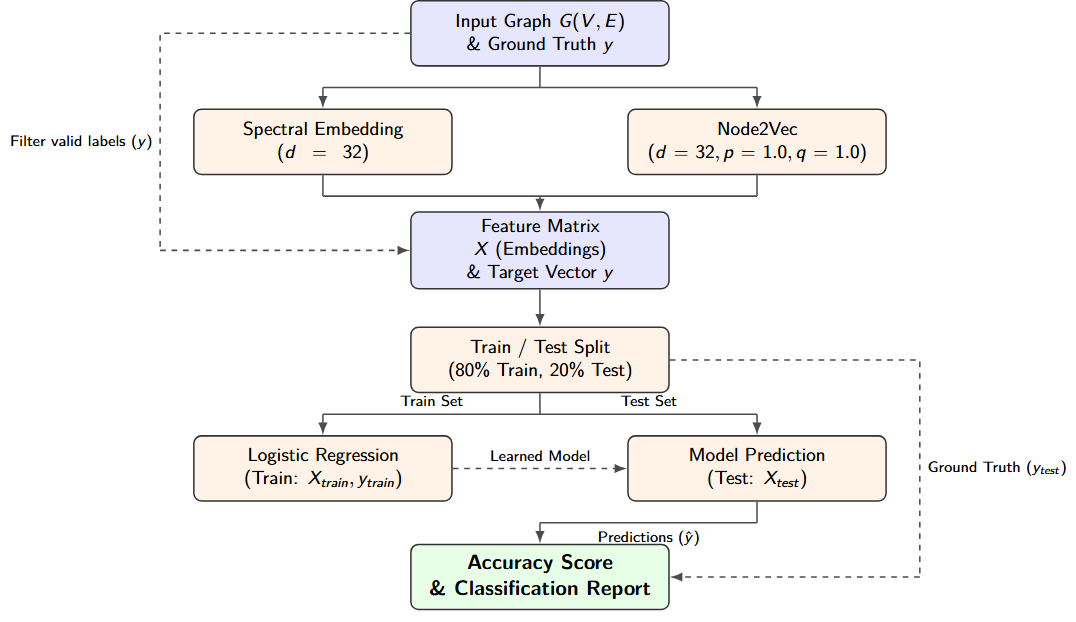

*Figure: Node-classification comparison for shallow embeddings on the Email-Eu-Core graph.*



=== Downstream Task: Node Classification (Email-Eu-Core) ===
--- Evaluating Spectral on Email-Eu-Core ---
   > Accuracy: 0.1061
--- Evaluating Node2Vec on Email-Eu-Core ---
   > Accuracy: 0.8283


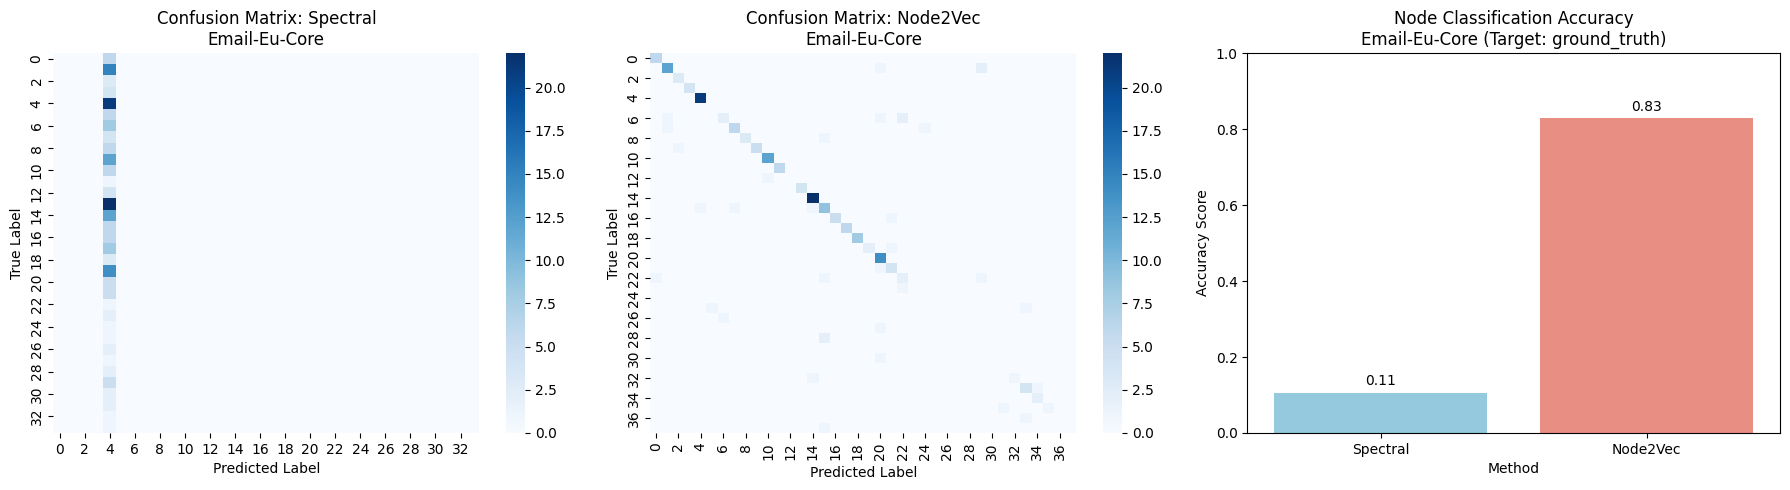

In [38]:
# EVALUATION
# Email-Eu-Core (Predicting Department)
compare_downstream_tasks(G_email, emb_email_spec, emb_email_n2v, "Email-Eu-Core", "ground_truth")

### The "Email-Eu-Core" Result
The Data: Spectral (0.11) vs. Node2Vec (0.83).
Conclusion: Spectral Embedding failed completely, while Node2Vec performed excellently.

Misalignment of Objectives: Spectral embedding minimizes the global cut. It looks for the mathematically "strongest" way to split the graph. The result suggests that the "Department" labels are not the primary structural divisions of this graph. Spectral likely found other latent structures (e.g., hierarchy levels or mailing list groups) and partitioned the graph based on those, ignoring the departments.

The "Collapse" Problem: As we saw in the visualization (the "Islands"), Spectral likely collapsed the majority of the nodes (the dense core) into a single, indistinguishable blob to focus on separating the outliers. The Logistic Regression model could not disentangle the 42 departments from that collapsed blob, resulting in near-random accuracy ($1/42 \approx 2\%$, so $11\%$ is barely better).

Node2Vec's Strength: Node2Vec captured homophily (people tend to email others in the same department). By optimizing for local neighborhood probability (not global cuts), it expanded the dense core, making the departments linearly separable.

## Testing the Linear Separability of Embeddings

Now that we have our embeddings, a great way to test their quality is to swap out the "head" (the downstream classifier).

If an embedding algorithm is truly good, it should project the complex graph structure into a space where the communities are linearly separable. To test this, we will compare a simple linear model (Logistic Regression) against more complex, non-linear models (SVM with an RBF kernel, Random Forest, and a Neural Network/MLP).

The baselines were configured as follows:

- **Logistic Regression**: `LogisticRegression(max_iter=1000, random_state=42)`
- **SVM**: `SVC(kernel='rbf', random_state=42)`. Unlike a straight line, the Radial Basis Function (RBF) kernel maps the data into a higher-dimensional space to draw curved, non-linear boundaries around the classes. We used the default scikit-learn hyperparameters (C=1.0, scale gamma).
- **Random Forest**: `RandomForestClassifier(n_estimators=100, random_state=42)`. We used an ensemble of 100 separate decision trees to prevent overfitting while capturing highly complex, jagged boundaries.
- **Neural Network (MLP)**: `MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)`. We used a two-layer architecture. The 32D embeddings expand into a 64-neuron hidden layer to capture complex combinations, then compress into a 32-neuron layer before the final classification. We chose ReLU ($\sigma(z) = \max(0,z)$) as it introduces the necessary non-linearity into the network while preventing the vanishing gradient problem often associated with Sigmoid or Tanh functions. Under the hood, this classifier automatically uses Categorical Cross-Entropy (Log Loss) for multi-class classification.


=== Comparing Classification Heads (Email-Eu-Core) ===
   > Training models on Spectral Embeddings...
   > Training models on Node2Vec Embeddings...


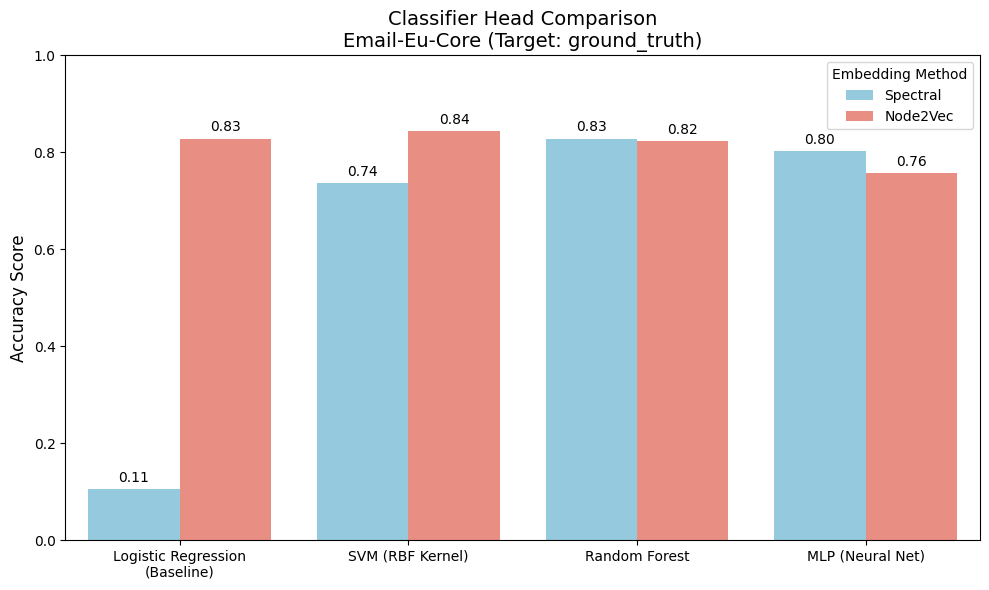

In [39]:
# Test on Email Dataset
compare_classifier_heads(G_email, emb_email_spec, emb_email_n2v, "Email-Eu-Core", "ground_truth")

### Why did non-linear models perform better on Spectral embeddings?

The department information was actually captured by the Spectral embedding, but it was highly tangled and non-linear. A simple straight line (Logistic Regression) couldn't separate the departments, but a complex, non-linear tree algorithm was able to carve out the convoluted boundaries.

For Node2Vec, the performance stays incredibly consistent, hovering around $0.76 - 0.84$, regardless of whether we use a simple linear model or a heavier Neural Network.

# Link predictor evaluator

We now hide 10% of the edges, retrain the embeddings on the remaining graph, and then check if the embeddings can "rediscover" the hidden edges.

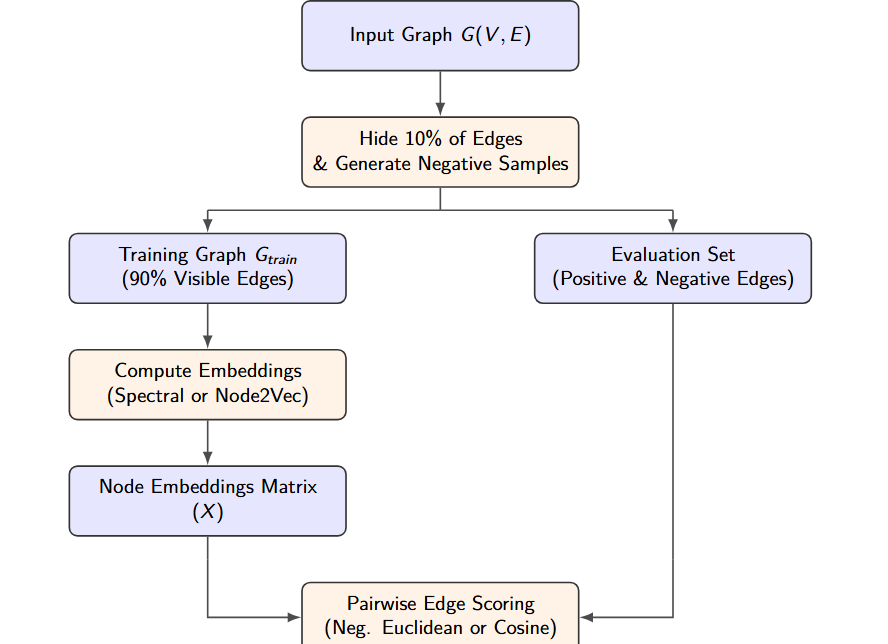

*Figure: Link-prediction performance comparison on the Email-Eu-Core graph.*


--- Link Prediction Pipeline: Email-Eu-Core (spectral) ---
   > Splitting edges for Link Prediction...
   > Computing Spectral Embedding (d=32)...
   > Link Prediction AUC: 0.8518

--- Link Prediction Pipeline: Email-Eu-Core (node2vec) ---
   > Splitting edges for Link Prediction...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=1.0)...
   > Link Prediction AUC: 0.8820


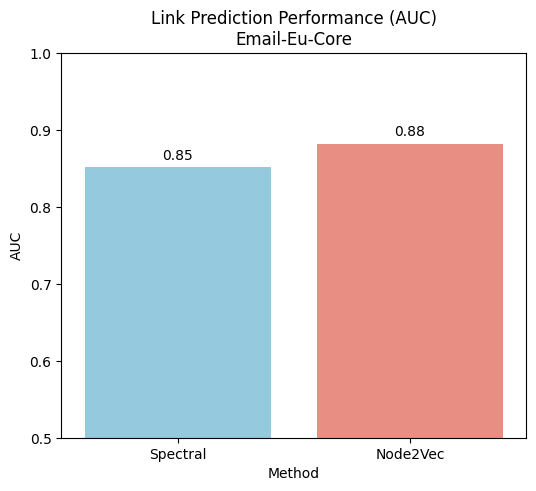

In [40]:
# We compare both methods on the Email graph (faster to run)
auc_spec = evaluate_link_prediction(G_email, "Email-Eu-Core", method="spectral")
auc_n2v  = evaluate_link_prediction(G_email, "Email-Eu-Core", method="node2vec")

# Visualization
df_lp = pd.DataFrame({'Method': ['Spectral', 'Node2Vec'], 'AUC': [auc_spec, auc_n2v]})
plt.figure(figsize=(6, 5))
sns.barplot(data=df_lp, x='Method', y='AUC', palette=['skyblue', 'salmon'])
plt.title("Link Prediction Performance (AUC)\nEmail-Eu-Core")
plt.ylim(0.5, 1.0)
for index, row in df_lp.iterrows():
    plt.text(index, row.AUC + 0.01, f"{row.AUC:.2f}", color='black', ha="center")
plt.show()

Link Prediction relies on 'closing triangles' (common neighbors). Spectral embedding is good at this because it places connected nodes close together. However, Node2Vec performs better because its random walks explicitly sample these local triangles (High-order proximity), making the cosine similarity between unconnected-but-close neighbors much more accurate.

## Node2Vec Parameter Grid Search

We add a parameter sensitivity analysis (Grid Search) for $p$ and $q$. We are testing Homophily vs. Structural Equivalence.

This script will likely take a few minutes to run (since it trains embeddings many times).


=== Optimizing Node2Vec Parameters for Email-Eu-Core (Both Tasks) ===
   > Preparing Link Prediction train/test split...
   > Splitting edges for Link Prediction...
   > Testing combination 1/9: p=0.25, q=0.25...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=0.25)...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=0.25)...
   > Testing combination 2/9: p=0.25, q=1...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=1)...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=1)...
   > Testing combination 3/9: p=0.25, q=4...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=4)...
   > Computing Node2Vec Embedding (d=32, p=0.25, q=4)...
   > Testing combination 4/9: p=1, q=0.25...
   > Computing Node2Vec Embedding (d=32, p=1, q=0.25)...
   > Computing Node2Vec Embedding (d=32, p=1, q=0.25)...
   > Testing combination 5/9: p=1, q=1...
   > Computing Node2Vec Embedding (d=32, p=1, q=1)...
   > Computing Node2Vec Embedding (d=32, p=1, q=1)...
   > Testing combination 6/9: p=1, q=4.

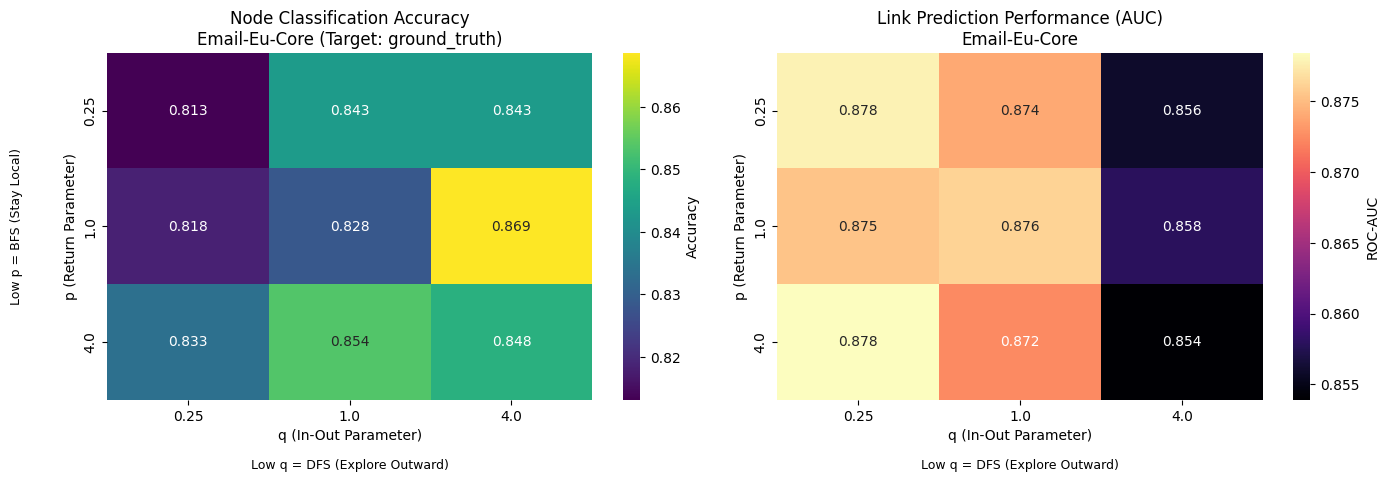


Best Config for Node Classification: p=1.0, q=4.0 -> Accuracy: 0.8687
Best Config for Link Prediction:     p=4.0, q=0.25 -> AUC: 0.8784


,p,q,Accuracy,AUC
0,0.25,0.25,0.813131,0.877766
1,0.25,1.00,0.843434,0.873930
2,0.25,4.00,0.843434,0.855893
3,1.00,0.25,0.818182,0.875367
4,1.00,1.00,0.828283,0.876182
5,1.00,4.00,0.868687,0.857925
6,4.00,0.25,0.833333,0.878400
7,4.00,1.00,0.853535,0.872431
8,4.00,4.00,0.848485,0.853924


In [41]:
# We use values [0.25, 0.5, 1, 2, 4] to cover the range from "tight local" to "wide global"
p_grid = [0.25, 1, 4]
q_grid = [0.25, 1, 4]

# Run on Email Graph
optimize_node2vec_params_both_tasks(G_email, "ground_truth", "Email-Eu-Core", p_grid, q_grid)

**Notes on Node Classification Task**

The probability of moving outward is proportional to $1/q$. A high $q$ (4.0) means a low probability ($1/4$) of moving away. This forces the random walker to stay local (BFS behavior).

Since the task is predicting Departments, this makes perfect sense. People in the same department email each other frequently. A walker that stays inside the "department cluster" learns better representations than one that runs away to other parts of the graph.

The model performs worst when $q$ is low (e.g., $q=0.25$). A low $q$ means a high probability ($1/0.25 = 4$) of moving outward (DFS behavior).

**General Remarks**:

We used Accuracy for Node Classification because it is a discrete, multi-class prediction task. However, for Link Prediction, the model outputs a continuous similarity score rather than a binary label. We used ROC-AUC because it evaluates how well the embeddings inherently rank true edges above non-existent edges, allowing us to measure the quality of the latent space without relying on an arbitrary classification threshold.

# Part 2: Graph Neural Networks (GNNs)

## Part 2.1 Node Classification with GAT (Graph Attention Network)

### Why did we choose GAT (Graph Attention Network)?

While standard GCNs calculate a fixed average of a node's neighbors, Graph Attention Networks (GAT) introduce a learned Attention Mechanism ($\alpha_{ij}$). This is important in the case of this dataset as:

- **Neighbor Weighting:** It allows the model to learn that while an employee might email 50 different people, only the few core members of their specific department should heavily influence their embedding.
- **Self-Loops:** We add Self-loops to make sure the model preserves a node's own structural identity alongside neighborhood information during aggregation.

Important details of the GAT pipeline:

- **Initialization with Identity Matrix:** Since the Email dataset lacks raw node attributes, we initialize the nodes with an Identity Matrix. This forces the GNN to learn purely from the graph's topology.
- **The Masking Strategy:** Instead of physically splitting the graph, we use masks. The GNN "sees" the entire graph but only calculates the Categorical Cross-Entropy Loss based on the nodes in the training mask.

The full pipeline for node classification with GAT is as follows:

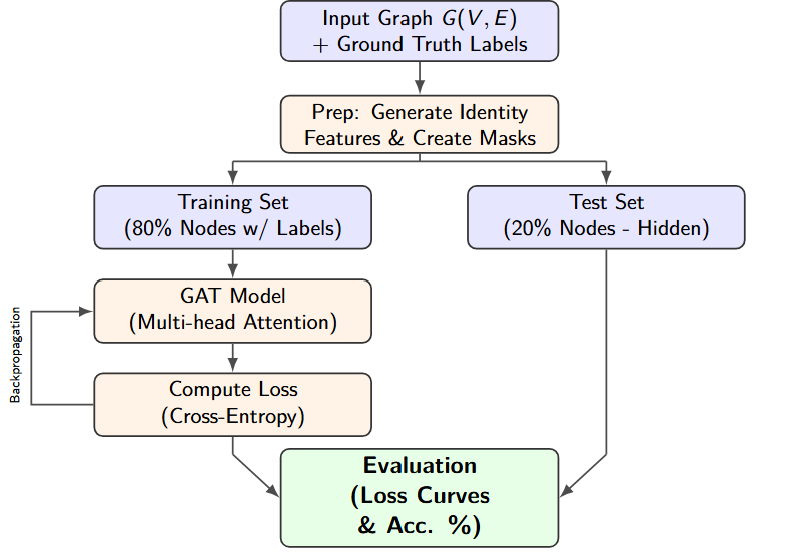

*Figure: GNN-based node-classification result on the Email-Eu-Core graph.*


=== GAT ML Pipeline: Email-Eu-Core ===
   Epoch 0000 | Loss: 3.7367 | Accuracy: 0.0253
   Epoch 0200 | Loss: 1.4286 | Accuracy: 0.6414
   Epoch 0400 | Loss: 1.0217 | Accuracy: 0.6667
   Epoch 0600 | Loss: 0.9521 | Accuracy: 0.7273
   Epoch 0800 | Loss: 0.8742 | Accuracy: 0.6465
   Epoch 1000 | Loss: 0.8564 | Accuracy: 0.6970


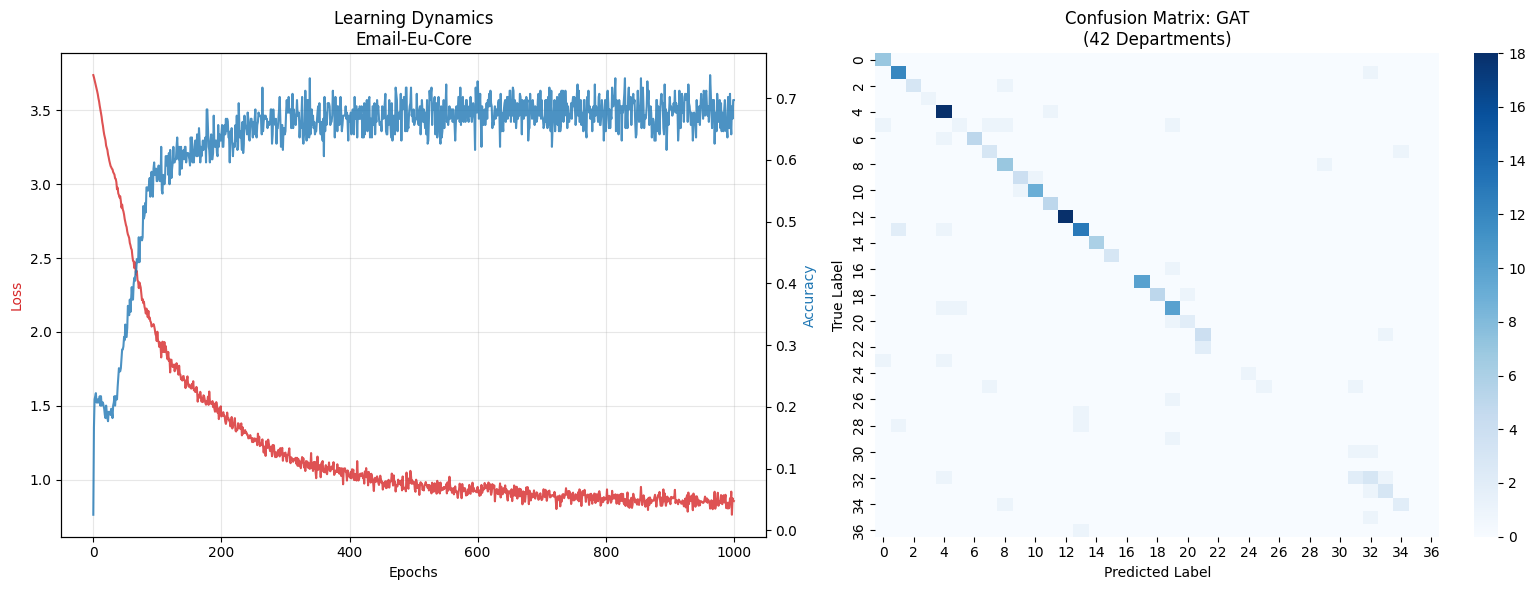

In [58]:
# Execution
gat_acc_email = run_gat_ml_side_by_side(G_email)

## Part 2.2 Link Prediction with GAT (Graph Attention Network)

The following is the description of the pipeline:

- **The Encoder (GAT):** The GAT layers act as the encoder, taking the graph structure (and identity features) to produce latent node embeddings, denoted as $\mathbf{z}_u$.
- **The Decoder (Dot Product):** To predict a link, the decoder takes two node embeddings and computes their similarity, using a dot product: $score = \mathbf{z}_u^\top \mathbf{z}_v$. A high score indicates a high probability of an edge.
- **Negative Sampling:** To train the model, we must provide examples of what a link is not. We generate "negative samples" (pairs of nodes that do not have an actual edge, so the model learns to assign them low similarity scores).

The full pipeline for link prediction with GAT is as follows:

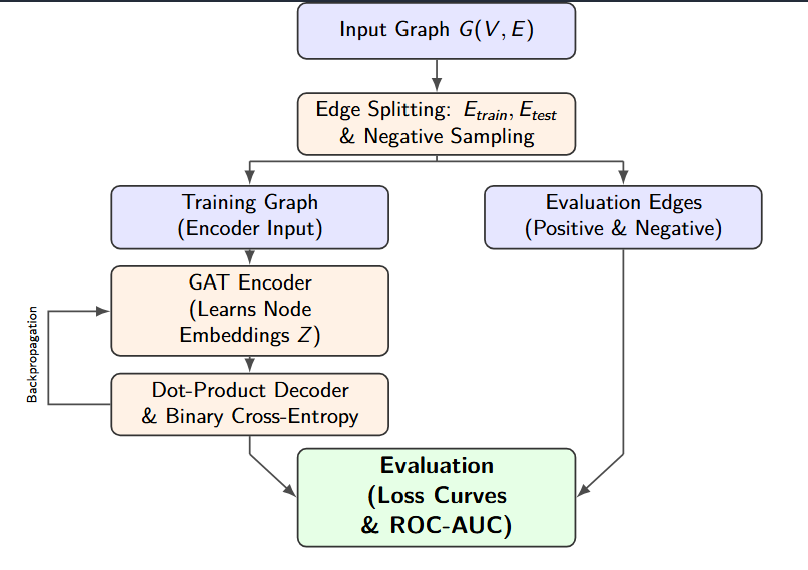

*Figure: GNN-based link prediction result on the Email-Eu-Core graph.*


=== GAT Link Prediction Pipeline: Email-Eu-Core ===
   Epoch 000 | Loss: 0.6931 | AUC: 0.5700
   Epoch 050 | Loss: 0.6366 | AUC: 0.7314
   Epoch 100 | Loss: 0.6276 | AUC: 0.7616
   Epoch 150 | Loss: 0.6247 | AUC: 0.7789
   Epoch 200 | Loss: 0.6191 | AUC: 0.7810
   Epoch 250 | Loss: 0.6200 | AUC: 0.7846
   Epoch 300 | Loss: 0.6210 | AUC: 0.7732
   Epoch 350 | Loss: 0.6260 | AUC: 0.7737
   Epoch 400 | Loss: 0.6199 | AUC: 0.7826
   Epoch 450 | Loss: 0.6249 | AUC: 0.7816
   Epoch 500 | Loss: 0.6175 | AUC: 0.7809
   Epoch 550 | Loss: 0.6225 | AUC: 0.7823
   Epoch 600 | Loss: 0.6221 | AUC: 0.7848
   Epoch 650 | Loss: 0.6227 | AUC: 0.7816
   Epoch 700 | Loss: 0.6205 | AUC: 0.7767
   Epoch 750 | Loss: 0.6217 | AUC: 0.7764
   Epoch 800 | Loss: 0.6197 | AUC: 0.7810
   Epoch 850 | Loss: 0.6182 | AUC: 0.7841
   Epoch 900 | Loss: 0.6205 | AUC: 0.7822
   Epoch 950 | Loss: 0.6218 | AUC: 0.7807
   Epoch 1000 | Loss: 0.6210 | AUC: 0.7802


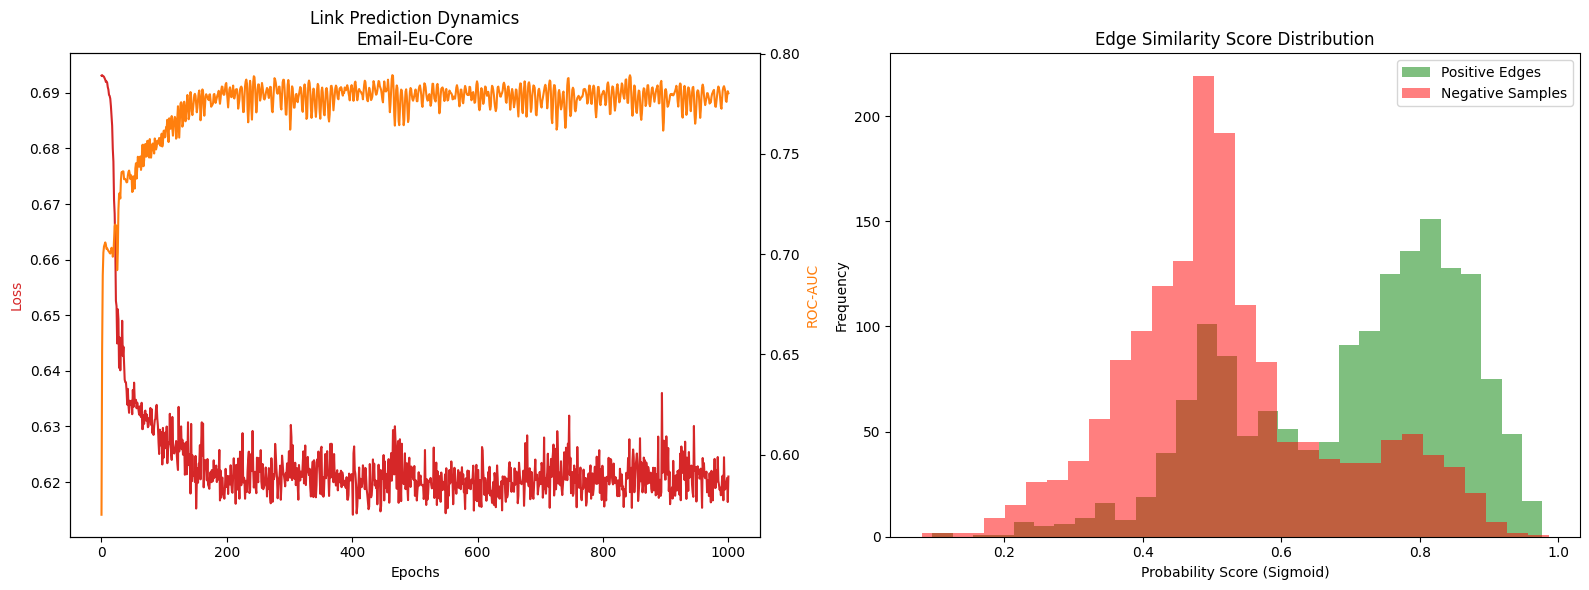

In [43]:
# Run Link Prediction
lp_auc = run_gat_link_prediction(G_email)

## Why did shallow embeddings perform better than GNNs on this dataset?

This phenomenon was observable on both the node classification and link prediction tasks, where Node2Vec outperformed GAT. The reasons for this are likely the follwowing:

1. **Lack of Node Attributes**: GNNs like GAT are designed to fuse graph structure with node features (e.g., text, images, user profiles). Since the Email dataset has no features, we just used an Identity Matrix. This forces the GAT to learn "from scratch" using only the adjacency matrix.

2. **Size and Complexity of the Graph**: GNNs are models that typically require large amounts of data and rich features to generalize well. Node2Vec, being a simpler "shallow" method, is very good at at capturing local homophily, meaning the tendency of nodes to connect with similar others and it does not need feature-based guidance.

3. **The Over-Smoothing Risk:** In dense networks like Email-Eu-Core (see the first notebook for details), repeated aggregations in GNNs can lead to over-smoothing, where the embeddings of all nodes start to look the same. Node2Vec avoids this by focusing purely on random walk probabilities to define local neighborhoods.